<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture2/batch_layer_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Batch NormalizationとLayer Normalization

In [115]:
# googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
%cd /content/drive/MyDrive/Deep_Learning/DL_Lecture2

/content/drive/MyDrive/Deep_Learning/DL_Lecture2


In [117]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch import nn, optim
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Hook

NNモデルの層(nn.Module)やtensorに対して勾配計算時などのタイミングで特定の関数を実行することができる。
* tensorに対しては、`register_hook()`を使用する。--> tensorの勾配計算の直後に引数で渡した関数を実行する。
* nn.Moduleに対しては以下のメソッドでhookを登録する<br>
  1. Forward Hook<br>
    nn.Moduleの`forward`メソッドが呼び出された直後に実行される関数を定義<br>
    特定の層の出力を記録することができる<br>
    nn.Moduleオブジェクトに対して`.register_forward_hook()`に関数を渡す
  2. Backward Hook<br>
    逆伝播の間に勾配の計算が行われた直後に実行される関数を定義
    勾配の値を記録したり、勾配に変更を加えたりすることが可能
    nn.Moduleオブジェクトに対して`.register_full_backward_hook()`に関数を渡す

#### .register_hook()

In [118]:
a = torch.ones(5, requires_grad=True)
b = 2 * a
b.retain_grad()
b.register_hook(lambda grad: print(grad)) # --> bの勾配が出力される
c = b.mean()
c.backward()

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


#### .register_forward_hook()

• nn.Moduleに対して`.register_forward_hook(func)`でhookを登録する<br>
• model.named_modules()等でモデルのモジュールをイテレーションすることで，モデルの各層(モジュール)にhookをつけることができる<br>
• 自動で３つの引数を受け取る<br>
1. module: hookが登録されているモジュールそのもの(nn.Module)<br>
2. input: そのモジュールの入力
3. output: そのモジュールの出力

In [119]:
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2
    nn.Flatten(),
    # 32 x 1 x 1
    nn.Linear(32*2*2, 10)
    # 10
)

outputs = {}
def save_output(name, module, input, output):
    module_name = f"{name}_{str(module)}"
    outputs[module_name] = output.shape

for name, module in conv_model.named_modules():
    if name: # 自分自身のmoduleにはhookをつけない
        module.register_forward_hook(partial(save_output, name))

**[補足]**<br>
`.register_forward_hook(fanc)`でfanc(関数)`save_output`を用いる時に、引数の数の違いが生じてしまう。<br>
`.register_forward_hook(func)`では通常、自動で３つの引数をfanc(関数)に与えることになっている。しかし、`save_output`関数では4つの引数を必要としている。<br>

この問題を解決するために、`functools.partial`を使って関数の一部の値を固定して新しい関数を作成することができる。

In [120]:
from functools import partial
# 元となる関数の定義
def power(base, exponent):
 return base ** exponent
# 部分適⽤した関数の作成
square = partial(power, exponent=2)
# 部分適⽤した関数の利⽤
print(square(5)) # 出⼒：25

25


In [121]:
def print_hooks(model):
    for name, module in model.named_modules():
        if hasattr(module, "_forward_hooks"):
            for hook in module._forward_hooks.values():
                print(f'Module {name} has forward hook: {hook}')

        if hasattr(module, "_backward_hooks"):
            for hook in module._backward_hooks.values():
                print(f'Module {name} has backward hook: {hook}')

In [122]:
print_hooks(conv_model)

Module 0 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '0')
Module 1 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '1')
Module 2 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '2')
Module 3 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '3')
Module 4 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '4')
Module 5 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '5')
Module 6 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '6')
Module 7 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '7')
Module 8 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '8')
Module 9 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '9')


In [123]:
# forwardでhook発動
X = torch.randn((1, 1, 28, 28))
output = conv_model(X)

In [124]:
outputs

{'0_Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 4, 14, 14]),
 '1_ReLU()': torch.Size([1, 4, 14, 14]),
 '2_Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 8, 7, 7]),
 '3_ReLU()': torch.Size([1, 8, 7, 7]),
 '4_Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 16, 4, 4]),
 '5_ReLU()': torch.Size([1, 16, 4, 4]),
 '6_Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 32, 2, 2]),
 '7_ReLU()': torch.Size([1, 32, 2, 2]),
 '8_Flatten(start_dim=1, end_dim=-1)': torch.Size([1, 128]),
 '9_Linear(in_features=128, out_features=10, bias=True)': torch.Size([1, 10])}

#### .register_full_backward_hook()

• nn.Moduleに対して.register_full_backward_hook(func)でhookを登録する<br>
  ・ モジュールの入力と出力の勾配に対するhookを設定する<br>
  ・ 勾配の変更や監視などの操作を実行したいときに使用<br>
• model.named_modules()等でモデルのモジュールをイテレーションすることで，モデルの各層(モジュール)にhookをつけることができる<br>
• .backward()で逆伝播をし,各モジュールの勾配を計算した後にhookに登録した関数が実行される<br>
• 自動で３つの引数を受け取る<br>
  1. module: hookが登録されているモジュールそのもの(nn.Module)<br>
  2. grad_in: そのモジュールの入力の勾配<br>
  3. grad_out: そのモジュールの出力の勾配

In [125]:
conv_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [126]:
grads = {}
def save_grad_in(name, module, grad_in, grad_out):
    module_name = f"{name}_{str(module)}"
    grads[module_name] = grad_in

for name, module in conv_model.named_modules():
    if name:
        module.register_full_backward_hook(partial(save_grad_in, name))

In [127]:
print_hooks(conv_model)

Module 0 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '0')
Module 0 has backward hook: functools.partial(<function save_grad_in at 0x7962227f9480>, '0')
Module 1 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '1')
Module 1 has backward hook: functools.partial(<function save_grad_in at 0x7962227f9480>, '1')
Module 2 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '2')
Module 2 has backward hook: functools.partial(<function save_grad_in at 0x7962227f9480>, '2')
Module 3 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '3')
Module 3 has backward hook: functools.partial(<function save_grad_in at 0x7962227f9480>, '3')
Module 4 has forward hook: functools.partial(<function save_output at 0x79622293fe20>, '4')
Module 4 has backward hook: functools.partial(<function save_grad_in at 0x7962227f9480>, '4')
Module 5 has forward hook: functools.partial(<function save_output at 

In [128]:
# backward
X = torch.randn((1, 1, 28, 28))
output = conv_model(X)
loss = output.mean()
loss.backward()

In [129]:
grads

{'9_Linear(in_features=128, out_features=10, bias=True)': (tensor([[-0.0048, -0.0176,  0.0003,  0.0021,  0.0140, -0.0192, -0.0027,  0.0040,
           -0.0111,  0.0526, -0.0013,  0.0028, -0.0142,  0.0176,  0.0025, -0.0150,
            0.0202,  0.0406, -0.0009, -0.0299,  0.0008,  0.0026, -0.0125, -0.0268,
           -0.0169, -0.0037,  0.0062, -0.0036, -0.0001, -0.0121, -0.0325, -0.0048,
           -0.0072,  0.0155, -0.0194, -0.0373, -0.0191,  0.0308, -0.0045,  0.0071,
           -0.0002, -0.0192, -0.0287,  0.0194,  0.0076,  0.0069, -0.0035, -0.0022,
            0.0054,  0.0043, -0.0140,  0.0274, -0.0129, -0.0055, -0.0064,  0.0331,
           -0.0297,  0.0112, -0.0066, -0.0043,  0.0076,  0.0099,  0.0011, -0.0024,
            0.0042,  0.0057,  0.0084, -0.0212, -0.0396,  0.0189,  0.0032, -0.0289,
           -0.0006, -0.0066,  0.0215,  0.0256, -0.0051,  0.0084, -0.0090,  0.0116,
            0.0066, -0.0142, -0.0074,  0.0014, -0.0184, -0.0024, -0.0042,  0.0065,
           -0.0126,  0.0093, -

### Activationの分布

In [130]:
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32 x 1 x 1

    nn.Flatten(),
    # # 128 -> 32
    nn.Linear(128, 10)
    # nn.Linear(32, 10)
    # 10
)

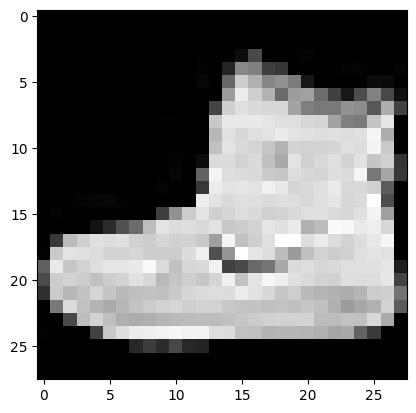

In [131]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,) )
])
train_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=False, download=True, transform=transform)

# 画像を再構築
plt.imshow(train_dataset[0][0].squeeze(), cmap='gray')

In [132]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [133]:
# forward hook


# def save_out_stats(i, module, inp, out):
#     act_means[i].append(out.mean().item())
#     act_stds[i].append(out.std().item())

# relu_layers = [module for module in conv_model if isinstance(module, nn.ReLU)]
# for i, relu in enumerate(relu_layers):
#     relu.register_forward_hook(partial(save_out_stats, i))

# ↓クラス化↓

class ActivationStatistics:
    def __init__(self, model):
        self.model = model
        self.act_means = [[] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [[] for module in self.model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))

    def save_out_stats(self, i, module, inp, out):
        if self.model.training: # --> 学習データに対してのみActivationをtrackする
            self.act_means[i].append(out.detach().cpu().mean().item())
            self.act_stds[i].append(out.detach().cpu().std().item())

    def get_statistics(self):
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title('Activation means')
        axs[0].legend(range(len(self.act_means)))

        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title('Activation stds')
        axs[1].legend(range(len(self.act_stds)))

        plt.show()


In [134]:
act_stats = ActivationStatistics(conv_model)

In [135]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=4)

optimizer = optim.Adam(conv_model.parameters(), lr=0.05)

In [136]:
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, optimizer, F.cross_entropy, 3)

epoch: 0: train error: 0.9826297310449309, validation error: 0.5599545240402222, validation accuracy: 0.7958167254924774


epoch: 1: train error: 0.5061816330683433, validation error: 0.5027558118104934, validation accuracy: 0.8149095177650452


epoch: 2: train error: 0.4443862322023359, validation error: 0.44993841350078584, validation accuracy: 0.8340242326259613


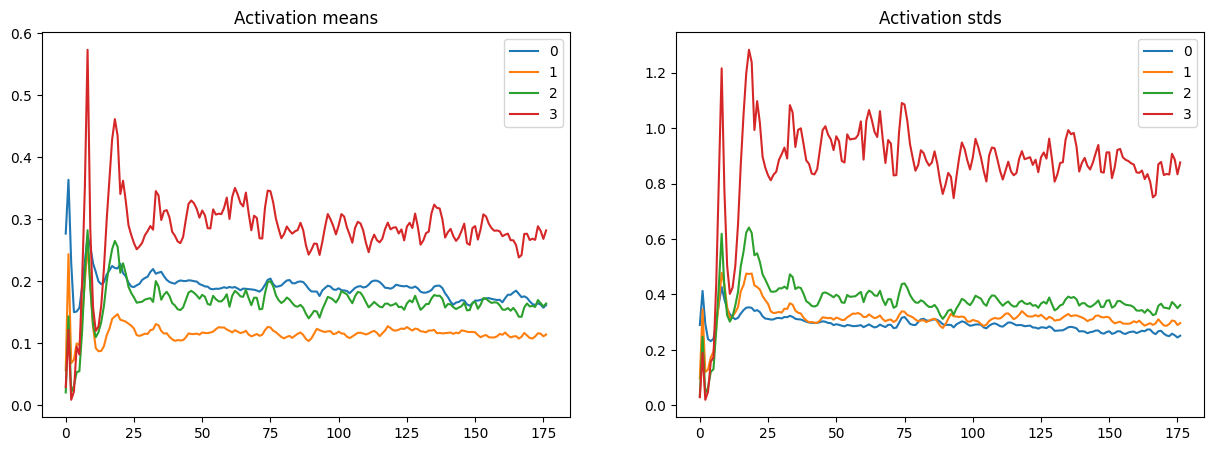

In [137]:
act_stats.plot_statistics()

上記に示す図の結果が、各層ごとの入力の分布である。横軸はステップ数を、縦軸には、アクティベーションの平均値と標準偏差を示している。<br>
層毎の入力の分布がバラバラであるのは、問題ないが、同じ層で激しくジグザクに入力の分布が動いてしまっているのは内部共変量シフトが発生していると考えられる。
また、層が深くなっていくほどばらつきが大きくなっていることも確認できる。

### Batch Normスクラッチ実装

In [138]:
# 全結合の場合はX.shape = [b, out_features]
# dim=(0)で平均，分散を求める

def batch_norm(x, gamma=1, beta=0, eps=1e-5):
    mean = x.mean(dim=(0, 2, 3), keepdim=True)
    var = x.var(dim=(0, 2, 3), keepdim=True)
    x_norm = (x - mean) / torch.sqrt(var + eps)
    return gamma * x_norm + beta

In [150]:
X = torch.randn(8, 3, 16, 16)
X[0][0]

tensor([[-0.7835,  0.3484,  1.2588, -2.1683, -0.2847, -1.0787,  0.5017, -0.1375,
          0.7749,  0.1782,  1.4673, -0.4007, -0.2024, -1.1624,  0.3298, -0.8457],
        [ 1.2854,  0.6518,  0.3163, -0.2511, -0.6878,  1.7966,  1.5613, -0.3981,
         -0.2610,  0.7463, -1.7392,  1.4911,  0.6398, -0.7525,  0.0628,  3.0952],
        [-0.5071, -0.8793,  1.0158, -1.0443, -0.3567,  0.9097,  0.9266, -1.4712,
         -1.7455,  0.6955, -0.4568, -1.7787,  0.0062,  0.0061, -1.3061,  1.1801],
        [-0.3399,  0.5226,  0.6236,  0.9527, -0.4176, -0.8270, -0.0146, -1.1024,
          1.5489,  0.8499, -0.1992,  1.4819, -0.8055,  0.1943,  1.4156,  0.3139],
        [ 1.2123, -0.2628, -0.0478, -0.2349,  0.8476, -0.4274,  0.5085, -0.6742,
          2.2869,  0.1816, -1.7170, -1.2145,  0.7457,  0.5028,  0.3124, -0.4779],
        [ 0.1102,  0.8409, -1.2969, -2.1022,  2.6223, -0.6192, -0.0482, -0.7765,
         -1.0947,  0.0166, -0.4830, -0.1964,  0.0885, -1.0172,  2.6258,  1.4621],
        [ 3.2269, -1.7

In [149]:
batch_norm(X)[0][0]

tensor([[ 1.1039e+00,  1.6512e-01,  1.6867e+00,  7.7608e-01, -7.8113e-01,
          2.1798e-02, -2.6475e-01,  3.1670e-01,  4.7181e-01, -1.4387e-02,
          3.5306e-01,  1.5134e+00, -8.2519e-01,  2.1343e+00,  9.0334e-01,
         -3.8154e-01],
        [ 3.6177e-02,  2.4910e-01,  2.0027e+00, -1.3575e+00, -1.3609e-01,
          3.7733e-01, -1.4621e-01,  4.1333e-01, -1.0624e+00, -1.4529e+00,
         -4.5351e-01,  5.6769e-01, -1.2654e+00, -1.1142e+00,  1.1131e+00,
         -1.0439e+00],
        [-6.5753e-01, -2.0124e+00, -8.0939e-03, -6.2960e-01, -6.6469e-01,
          7.8394e-01,  1.8729e+00,  1.4238e+00, -7.3179e-01,  1.4130e-01,
          3.8306e-01,  1.0218e+00, -3.3005e-01, -2.0770e+00,  1.0654e+00,
          1.1725e+00],
        [-5.6900e-01, -4.8947e-01,  3.1206e-01, -1.3140e+00, -2.7587e-01,
          6.4818e-01, -4.7451e-02, -5.5961e-01, -3.9500e-01,  9.4827e-03,
          4.1446e-01, -5.0617e-01, -6.3176e-01, -9.3206e-01, -1.2142e+00,
          5.1775e-01],
        [-1.3814e-02

In [151]:
X, y = train_dataset[0]
X.shape

torch.Size([1, 28, 28])

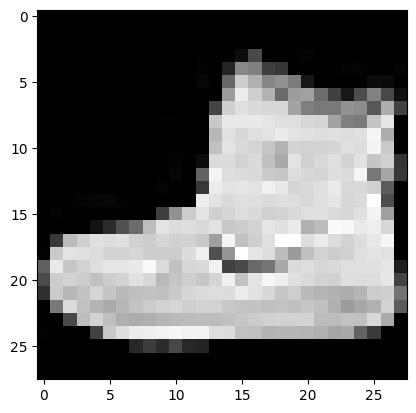

In [152]:
X = X /2 + 0.5
plt.imshow(np.transpose(X, (1, 2, 0)), cmap='gray')

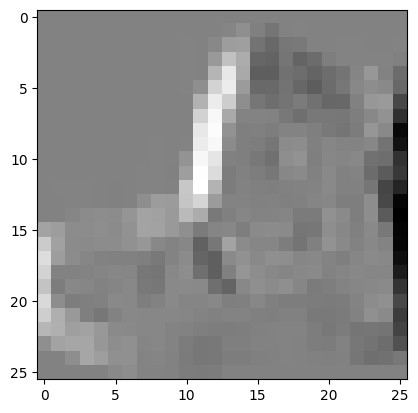

In [153]:
def apply_filter(im, filter):
    im_h, im_w = im.shape
    f_h, f_w = filter.shape
    output_data = []
    for i in range(im_h - f_h + 1):
        row = []
        for j in range(im_w - f_w + 1):
            row.append((im[i:i+f_h, j:j+f_w] * filter).sum().item())
        output_data.append(row)
    return torch.tensor(output_data)

left_edge_filter = torch.tensor([[-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1]])
def relu(X):
    return torch.clamp(X, min=0)
X_ = X[0, :, :]
conv_out = apply_filter(X_, left_edge_filter)
plt.imshow(conv_out, cmap='gray')

In [154]:
print(conv_out.mean(), conv_out.std())

tensor(0.0442) tensor(0.6041)


In [155]:
conv_out = conv_out[None, None, :, :]
norm_out = batch_norm(conv_out, )

In [156]:
norm_out.shape

torch.Size([1, 1, 26, 26])

In [157]:
print(norm_out.mean(), norm_out.std())

tensor(-1.4108e-08) tensor(1.0000)


In [158]:
relu_out = relu(norm_out)

In [159]:
relu_out = relu_out[0, 0, :, :]

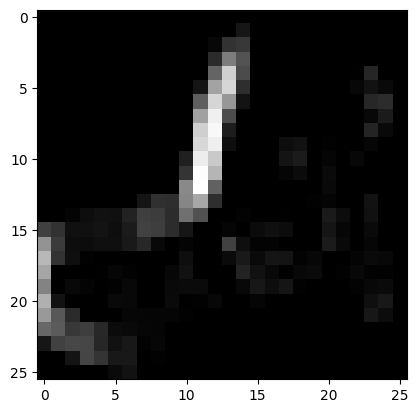

In [160]:
plt.imshow(relu_out, cmap='gray')

### nn.BatchNorm2d

In [161]:
X, y = next(iter(train_loader))
conv_out = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)(X)
norm_out = nn.BatchNorm2d(8)(conv_out)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [162]:
X.shape

torch.Size([1024, 1, 28, 28])

In [163]:
print(conv_out.mean(), conv_out.std())

tensor(-0.1167, grad_fn=<MeanBackward0>) tensor(0.4835, grad_fn=<StdBackward0>)


In [164]:
print(norm_out.mean(dim=(0, 2, 3)), norm_out.std(dim=(0, 2, 3)))

tensor([-5.3066e-08, -1.1214e-09, -4.0427e-08,  3.4782e-09,  9.1422e-09,
        -4.4466e-08, -2.3635e-08,  2.6229e-09], grad_fn=<MeanBackward1>) tensor([1.0000, 0.9996, 1.0000, 0.9999, 1.0000, 0.9999, 0.9999, 1.0000],
       grad_fn=<StdBackward0>)


In [165]:
list(nn.BatchNorm2d(8).parameters())

[Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

In [171]:
def get_conv_model():
    return  nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32 x 1 x 1

    nn.Flatten(),
    # # 128 -> 32
    nn.Linear(128, 10)
    # nn.Linear(32, 10)
    # 10
)

In [172]:
conv_model_w_bn = get_conv_model()

act_stats = ActivationStatistics(conv_model_w_bn)

optimizer = optim.Adam(conv_model_w_bn.parameters(), lr=0.05)
train_losses, val_losses, val_accuracies = utils.learn(conv_model_w_bn, train_loader, val_loader, optimizer, F.cross_entropy, 3)

epoch: 0: train error: 0.8366380369259139, validation error: 0.528778675198555, validation accuracy: 0.8033661484718323


epoch: 1: train error: 0.4720312200360379, validation error: 0.46417245268821716, validation accuracy: 0.8307138860225678


epoch: 2: train error: 0.4257557018328521, validation error: 0.4405575066804886, validation accuracy: 0.8383609712123871


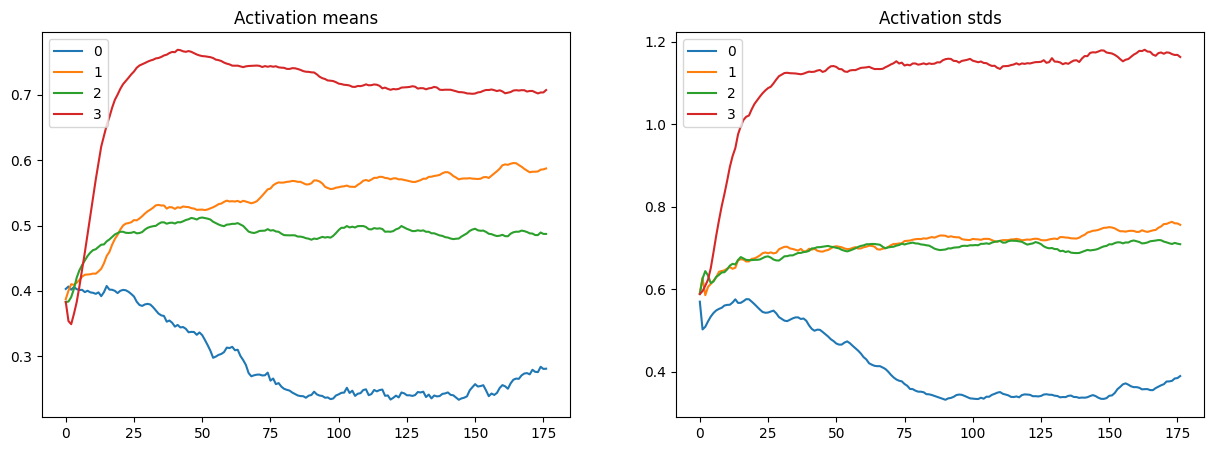

In [168]:
act_stats.plot_statistics()

上記は、バッチ正規化を含んだ後のステップ毎の入力分布の推移である。バッチ正規化を入れる前の推移と比較すると、ステップ毎の推移のばらつきがかなり減ったことがわかる。

### Layer norm スクラッチ実装

In [173]:
def layer_norm(X, gamma=1, beta=0, eps=1e-5):
    mean = X.mean(dim=(1, 2, 3), keepdim=True)
    var = X.var(dim=(1, 2, 3), keepdim=True)
    X_norm = (X - mean) / (torch.sqrt(var) + eps)
    return gamma*X_norm + beta

In [174]:
X = torch.randn(5, 3, 3, 3) * 3. + 10
norm_out = layer_norm(X)

In [175]:
norm_out.shape

torch.Size([5, 3, 3, 3])

### nn.LayerNorm()

In [176]:
X, y = next(iter(train_loader))
conv_out = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)(X)
norm_out = nn.LayerNorm([8, 14, 14])(conv_out)

In [177]:
print(conv_out[0].mean(), conv_out[0].std())

tensor(0.1017, grad_fn=<MeanBackward0>) tensor(0.4011, grad_fn=<StdBackward0>)


In [178]:
print(norm_out[0].mean(), norm_out[0].std())

tensor(-1.8246e-08, grad_fn=<MeanBackward0>) tensor(1.0003, grad_fn=<StdBackward0>)


In [181]:
def get_conv_model_ln():
    return  nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.LayerNorm([4, 14, 14]),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.LayerNorm([8, 7, 7]),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.LayerNorm([16, 4, 4]),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.LayerNorm([32, 2, 2]),
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32 x 1 x 1
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(32, 10)
    # 10
)
conv_model_w_ln = get_conv_model_ln()
act_stats = ActivationStatistics(conv_model_w_ln)
optimizer = optim.Adam(conv_model_w_ln.parameters(), lr=0.05)
train_losses, val_losses, val_accuracies = utils.learn(conv_model_w_ln, train_loader, val_loader, optimizer, F.cross_entropy, 3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                                                          

epoch: 0: train error: 0.9757722222198875, validation error: 0.5798609495162964, validation accuracy: 0.786316168308258


epoch: 1: train error: 0.48944465437177886, validation error: 0.46948004364967344, validation accuracy: 0.8308115422725677


epoch: 2: train error: 0.4133650170544447, validation error: 0.47724624574184416, validation accuracy: 0.8196966648101807


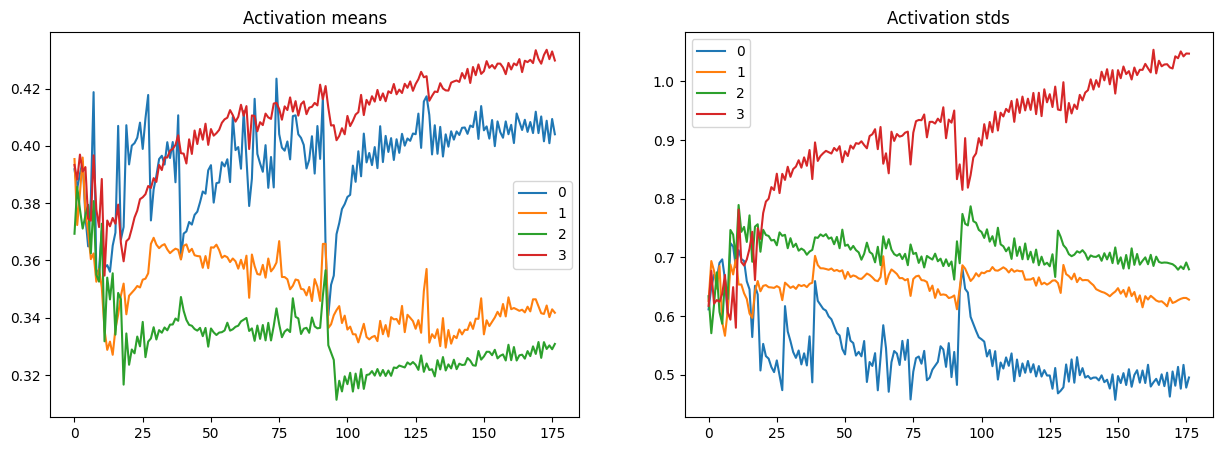

In [180]:
act_stats.plot_statistics()